In [1]:
import sys
if ".." not in sys.path:
    sys.path.append("..")

import warnings
import pandas as pd
import sklearn
import sklearn.datasets
import sklearn.model_selection
import sklearn.tree
import sklearn.linear_model
import sklearn.neural_network
import sklearn.metrics
import sklearn.ensemble
import matplotlib.pyplot as plt
import merci.evaluate

warnings.filterwarnings("ignore")

<frozen importlib._bootstrap>:241: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


## Evaluation of the robustness of a classification model type to distribution shifts

This evaluator measures how well a classification model maintains its performance when the training data distribution is altered. It can be used to pre-select models that are more suited for a particular dataset.

The evaluator achieves this by creating different training datasets with reduced proportions of one class, retraining the model on these altered datasets, and assessing its performance on a fixed test dataset using the F1 score. The average F1 score across different thresholds and classes gives an estimation of the model's robustness to distribution shifts.

Robust models are expected to have a high average F1 score across different thresholds and classes, while less robust models are expected to have a lower average F1 score.

As for the limitations, the evaluator only considers binary classification models and requires many retrains of the model, which can be computationally expensive.

Original paper [The quest for the reliability of machine learning models in binary classification on tabular data](https://www.nature.com/articles/s41598-023-45876-9)

To present the evaluator, we will use the [WBCD dataset](https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+(Diagnostic)). It contains 569 instances and 30 features and the goald is to predict whether the tumor is benign or malignant.

In [2]:
wbcd_dataset = sklearn.datasets.load_breast_cancer()
wbcd_data = wbcd_dataset["data"]
wbcd_target = wbcd_dataset["target"]

wbcd_df = pd.DataFrame(wbcd_data, columns=wbcd_dataset["feature_names"])
wbcd_df["target"] = wbcd_target

wbcd_df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


In [3]:
# dataset is fairly balanced

wbcd_df["target"].value_counts()

1    357
0    212
Name: target, dtype: int64

In [4]:
wbcd_data_train, wbcd_data_test, wbcd_target_train, wbcd_target_test = sklearn.model_selection.train_test_split(wbcd_data, wbcd_target, test_size=0.2, random_state=42)

In [5]:
classifiers = [
    sklearn.linear_model.LogisticRegression(random_state=42, max_iter=1000),
    sklearn.tree.DecisionTreeClassifier(random_state=42),
    sklearn.neural_network.MLPClassifier(hidden_layer_sizes=(10, ), max_iter=1000, random_state=42),
]
results = []
for clf in classifiers:
    clf.fit(wbcd_data_train, wbcd_target_train)
    wbcd_target_pred = clf.predict(wbcd_data_test)
    accuracy = sklearn.metrics.accuracy_score(wbcd_target_test, wbcd_target_pred)
    f1 = sklearn.metrics.f1_score(wbcd_target_test, wbcd_target_pred)
    irt_evaluator = merci.evaluate.DistributionShiftEvaluator(clf, (wbcd_data_train, wbcd_target_train),(wbcd_data_test, wbcd_target_test))
    irt_eval = irt_evaluator.evaluate()
    results.append({"Model": clf.__class__.__name__, "Accuracy": accuracy, "F1": f1, "Reliability Score": irt_eval})

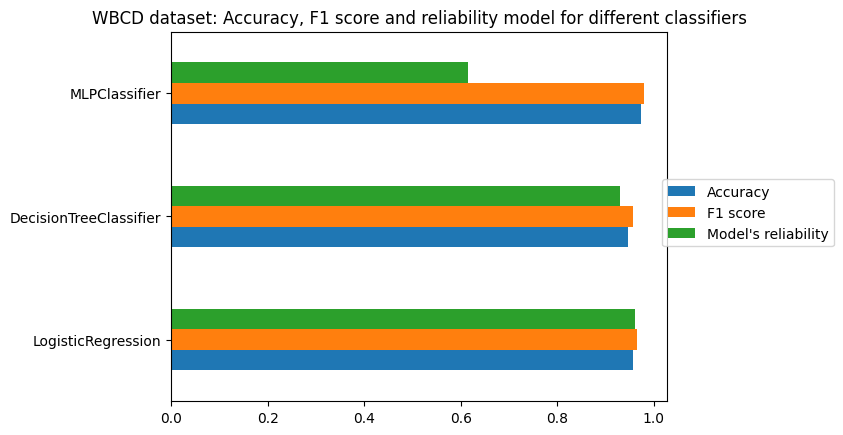

In [6]:
results_df = pd.DataFrame(results)

results_df.plot.barh(x="Model", y=["Accuracy", "F1", "Reliability Score"])
plt.ylabel("")

plt.title("WBCD dataset: Accuracy, F1 score and reliability model for different classifiers")
plt.legend(["Accuracy", "F1 score", "Model's reliability"], loc="lower right", bbox_to_anchor=(1.35, 0.4))
plt.show()

In [7]:
results_df

,Model,Accuracy,F1,Reliability Score
0,LogisticRegression,0.956140,0.965517,0.961081
1,DecisionTreeClassifier,0.947368,0.957746,0.930623
2,MLPClassifier,0.973684,0.979021,0.615964


The MLP model achieved significantly lower F1 scores than the other models, indicating that it is less robust to distribution shifts. A recommended decision based on this evaluation would be to opt for simpler model which yielded similar performance with much higher robustness.

The reason for the lower robustness of the MLP for this dataset, is that -- due to it being a more complex model -- it is more prone to overfitting to the training data. This means that when the distribution of the training data changes, the model's performance is more likely to deteriorate. Since the distribution of real-world data may be significantly different than the one we trained our model one, it is important to choose a model that is robust to potential distribution shifts. A less complex model, such as a logistic regression model or a decision tree, due to its simplicity is less likely to overfit to the training data and therefore more likely to maintain its performance when the distribution of the data changes.
